### use vgg16 model to train dog vs cat

This model REALLY needs to use GPU. Below shows the full utilization on AWS p2.xlarge
```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   81C    P0   141W / 149W |  11020MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      6018      C   ...naconda3/envs/tensorflow_p36/bin/python 11005MiB |
+-----------------------------------------------------------------------------+
```
And using 50 to 100% of available CPU
```
  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
6018 ec2-user  20   0   88.8g   6.0g   1.5g S 114.3 10.0   6:56.15 ZMQbg/1
```



In [31]:
import numpy as np
from tensorflow import keras
import glob
import cv2

In [32]:
# read one image to veify size
test_images = glob.glob('test/*/*.jpg')
train_images = glob.glob('train/*/*.jpg')

single_image = test_images[0]
img = cv2.imread(single_image)
h,w,c = img.shape
input_shape=(h,w,c)

print('input shape:', input_shape)

input shape: (224, 224, 3)


In [33]:
# define the model
def setup_vgg16_model(input_shape):
    
    model = keras.applications.vgg16.VGG16(include_top='False', input_shape=input_shape)
    # make all layers are not trainable
    
    for layer in model.layers:
        layer.trainable = False
        
    #model.summary()
    
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    
    # we want to connext out own dense after fc2
    x = layer_dict['fc2'].output
    
    # new output is adding flatten , dense(128) , and dense(1)
    
    x = keras.layers.Dense(128,activation='relu')(x)
    x = keras.layers.Dense(1,activation='sigmoid')(x)
    
    mymodel = keras.models.Model(inputs=model.input , outputs=x)
    opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    mymodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return mymodel


In [34]:
model = setup_vgg16_model(input_shape)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [35]:

batch_size=64

datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]
                                                       
train_iter = datagen.flow_from_directory('train/',class_mode='binary', target_size=(h,h), batch_size=batch_size)
test_iter = datagen.flow_from_directory('test/',class_mode='binary', target_size=(h,h), batch_size=batch_size)

print('length of iterations for train,test:', len(train_iter), len(test_iter))
                                                     

Found 18711 images belonging to 2 classes.
Found 6235 images belonging to 2 classes.
length of iterations for train,test: 293 98


In [36]:
#train the model with train data and check each epoch against test data
fit_history = model.fit_generator(train_iter, 
                                  steps_per_epoch=len(train_iter), 
                                  #workers=2,
                                  epochs=10,
                                  validation_data=test_iter,
                                  validation_steps=len(test_iter)
                    )

Epoch 1/10
293/293 [==============================] - 220s 750ms/step - loss: 0.0824 - acc: 0.9667 - val_loss: 0.0577 - val_acc: 0.9761
Epoch 2/10
293/293 [==============================] - 219s 749ms/step - loss: 0.0516 - acc: 0.9799 - val_loss: 0.0524 - val_acc: 0.9801
Epoch 3/10
293/293 [==============================] - 219s 749ms/step - loss: 0.0449 - acc: 0.9832 - val_loss: 0.0506 - val_acc: 0.9798
Epoch 4/10
293/293 [==============================] - 219s 748ms/step - loss: 0.0398 - acc: 0.9857 - val_loss: 0.0475 - val_acc: 0.9812
Epoch 5/10
293/293 [==============================] - 219s 747ms/step - loss: 0.0358 - acc: 0.9878 - val_loss: 0.0478 - val_acc: 0.9808
Epoch 6/10
293/293 [==============================] - 219s 747ms/step - loss: 0.0322 - acc: 0.9894 - val_loss: 0.0502 - val_acc: 0.9796
Epoch 7/10
293/293 [==============================] - 219s 747ms/step - loss: 0.0295 - acc: 0.9902 - val_loss: 0.0484 - val_acc: 0.9808
Epoch 8/10
293/293 [============================

In [37]:
model.save('vgg16_model.h5')

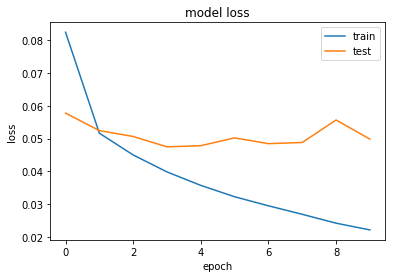

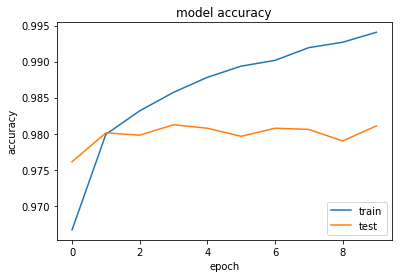

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

# show procession of training...
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.close()